# Getting Started

In this notebook we introduce basic concepts and functionality regarding use of the custom `cnn` library. Generally, this tutorial will cover just enough to begin using the `cnn` tools; for in-depth coverage of functionality please refer to the individual notebooks dedicated to each component of the `cnn` pipeline:

1. Import Data
2. Database Access and Manipulation
3. Annotation Platform
4. Algorithm Training
5. Inference and Validation

**Note:** The links embedded in this document are designed to jump directly the subsection within the above notebooks for further detail, however due to some quirks in Jupyter might require two clicks (one to open the notebook de novo, a second to jump to the notebook subsection) for full redirection.

## Overview

The key design paradigm of the `cnn` Python library is an interconnected network of classes that have been prebuilt with a number of key functionality needed to train deep learning algorithms, particularly those dealing with medical imaging. To train a new algorithm, simply overload (e.g. "adapt") key methods and/or variables of several key classes. The vast majority of common architectures can be quickly adapated for a particular problem in less than 100 lines of code, however can easily be extended to large, complex architectures as needed.

At minimum, the two key classes that need to be customized are the `Client` class (used for defining how to load data) and the `Model` class (used for defining the underlying CNN architecture model / graph). These (and many other default classes) are then combined into a final `Network` object to facilitate training as well as algorithn inference and validation:
```
net = cnn.Network()
net.Client = Client
net.Model = Model

net.initialize(
    app_context=app_context, 
    fold=0)
    
net.train()
```

Let's get started!

## Choosing GPU in Jupyter Notebooks

If you are using a Jupyter notebook to interface with code development on a machine with multiple GPUs, you must first start by selecting the GPU that you wish to use for network training. Keep in mind that by default Tensorflow will *allocate* every free GPU available, despite the fact that it cannot use more than a single GPU unless your code has been carefully parallelized. To select just a single GPU, use the Terminal command `nvidia-smi` to list the current status of the cards.

In [1]:
!nvidia-smi

Fri Sep  7 18:45:37 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.59                 Driver Version: 390.59                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0  On |                  N/A |
| 23%   19C    P8    16W / 250W |    357MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 23%   21C    P8    15W / 250W |  10962MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

To see which GPUs are free, look for large allocations of memory in the second column (`___MiB / 11178MiB`). Any GPU with a large fraction memory already allocated is likely in use. Once we identify an open GPU, use the following lines of code to select the device:

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER']= 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'            # Modify as needed
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/miniconda/envs/cnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/miniconda/envs/cnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/miniconda/envs/cnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2016332587123280581
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10560965837
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6316781733683673909
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3b:00.0, compute capability: 6.1"
]


## Import

These lines of code are used to import the necessary modules including the custom `cnn` library. Note here that the custom `montage` module is a pylab wrapper for quickly visualizing 3D grayscale images. Keep in mind that if your environment is not already preconfigured, you will need to set `$PYTHONPATH` with the necessary pointers using the `setenv.sh` script provided at the root of the repository.

In [3]:
import cnn
import numpy as np
from montage import montage
from show import show

Connect to viewer URL: http://160.87.25.45:7000/login.html?user=caidm 

# Client Class

The `cnn.utils.Client` class is used to interact with underlying database images. Before instantiating this class, one needs to provide the generic `Client` class with a context (`app_context` dict) that defines the data (and/or label) sources. The key `app_context` dictionary entries to define include:

* db: the name of MongoDB database containing data
* ip_mongodb: the IP address of the MongoDB daemon (by default, set to `127.0.0.1`)
* tags-series: list containing tags for series to load
* tags-labels: list containing tags for labels to load (if empty, no label mask is loaded)

Note that `tags-labels` refers to 2D or 3D volume mask data that need to be loaded from a separate file. Any single dimensional label data such as those for simple classification are stored directly in the MongoDB and are loaded automatically by the client (no special `tags-labels` need to be specified). For more information regarding `app_context` definition and maintenance see [01 - Import Data - Application Context](01_Import_Data.ipynb#Application-context).

## Data

In this example, we will be using the pre-imported BRaTS challenge database containing MRI exams from patients with brain tumors, loaded into the MongoDB under a database named `brats`. In this particular dataset, each patient was scanned with a total of four different modalities (series)---T2 (`brats-t2`), FLAIR (`brats-flair`), T1 precontrast (`brats-t1pre`) and T1 postcontrast (`brats-t1post`) exams. Note that each exam added in this list will simply be loaded and stacked along the channel (fourth) dimension, in the same order as this provided list. 

In [8]:
# Define application context to data and/or label sources
app_context = {
    'db': 'brats',
    'tags-series': ['brats-t2', 'brats-flair'],
    'tags-labels': ['tumor']
}

# Pass application context to Client() class to instantiate
client = cnn.utils.Client(app_context)

## Loading Data

To use the newly instantiated `Client` class, the simplest approach is via the `client.load_next()` method. Without any parameters, this will choose a random study and load its entire contents. The return variable is a dictionary, `vol`, containing two key entries:

* `vol['dat']`: 4D image volume (N x H x W x C)
* `vol['lbl']`: 4D label volume (N x H x W x C)

Here N = number of slices (N = 1 for 2D images) and C = number of different channels / modalities (C = 1 for single channel images e.g. plain film or CT). Note that if no `tags-labels` are provided then `vol['lbl']` will simply contain an empty list. For more information regarding various methods to load data using the `Client` class, please refer to [02 Database Access and Manipulation - Loading Data](02_Database_Access_and_Manipulation.ipynb#Loading-data).

In [25]:
def test_client_load():
    
    vol = client.load_next()
    
    return vol
    
vol = test_client_load()
print(vol['dat'].shape)
print(vol['lbl'].shape)

(155, 240, 240, 2)
(155, 240, 240, 1)


To view these 3D volumes, consider using the `montage()` function. To promote flexibility, `montage()` accepts a wide range of inputs from 2D to 4D matrices and simply makes a montage (tiled collage) of the volume along an ambiguous dimension (*non* height or width dimension shape > 1). For a 4D input of size N x H x W x C, the ambiguous dimensions are either the first (N) or last (C) dimension. If both N and C are greater than 1, N is by default the ambiguous dimension and C is automatically set to the first index; the resulting output display is a total of N tiles (slices) of the first volume channel. The chosen channel can of course alternatively be set by manually indexing into the array as needed. By contrast, if N is set to 1 and C is greater than 1, then all channels for a given slice will be displayed instead.

Some common example commands:

```
dat = vol['dat']
montage(dat)                   # Shows all slices of the first channel
montage(dat[::10])             # Shows every 10th slice of the first channel
montage(dat[..., 1])           # Shows all slices of the second channel
montage(dat[80])               # Shows all channels of the 80th slice
```

Feel free to try out these various combinations below (on `vol['dat']` and/or `vol['lbl']`.

## Infos dictionary

As needed, the default behavior for loading images can be specified using the `infos` dictionary. The most common specifications will relate to image resizing and/or slicing, and these in turn will most commonly be defined using the `shape` and `tiles` entries. Addition information for full `infos` dictionary use can be found in [02 - Database Access and Manipulation - Infos Dictionary](02_Database_Access_and_Manipulation.ipynb#Infos-dictionary).

### Volume resizing

To resize the entire image volume along any dimension, simply set the `infos['shape']` list to the desired target size. Keep in mind the N x H x W convention such that by default any 2D image should be defined as `[1, H, W]` (two-entry lists will fail). All specifications in the `infos` dictionary are automatically propogated to any associated label masks.

In [32]:
def test_client_load():
    
    # Resize 155 x 240 x 240 to 64 x 120 x 120
    infos = {
        'shape': [64, 120, 120],
        'tiles': [0, 0, 0]
    }
    
    vol = client.load_next(infos=infos)
    
    return vol

vol = test_client_load()
print(vol['dat'].shape)
print(vol['lbl'].shape)

(64, 120, 120, 2)
(64, 120, 120, 1)


### Volume slicing

To slice an image volume (load a portion of an image), simply set the desired shape and change the corresponding `tiles` to a non-zero value indicating the stride *distance* in millimeters (mm). For example a shape of `[5, 240, 240]` with a tiles of `[1, 0, 0]` indicates that random 5 contiguous slices with 1-mm spacing will be returned, whereas a tiles of `[3, 0, 0]` will increasing the spacing to 3-mm (every 3rd slice). If the original raw images imported into the database do not containg information about slice spacing (e.g. already anonymized and pre-coverted from original DICOM objects) then a default setting of 1-mm is asssumed. 

In [47]:
def test_client_load():
    
    infos = {
        'shape': [5, 240, 240],
        'tiles': [1, 0, 0]
    }

    vol = client.load_next(infos=infos)
    
    return vol

vol = test_client_load()
print(vol['dat'].shape)
print(vol['lbl'].shape)

(5, 240, 240, 2)
(5, 240, 240, 1)
Remote server (160.87.25.45:27787) recieved dat: size 288000
Remote server (160.87.25.45:27787) recieved lbl: size 1
Ready for viewing


## BRATS Dataset

Now that we understand how to load images, let us look at the BRATS dataset more closely. In addition to the four differnt modalities described above, a 3D mask label is provided for each patient containing one of four different labels at each voxel (3D pixel) in the exam:

* 1 = non-enhancing tumor
* 2 = edema
* 3 = necrosis
* 4 = enhancing tumor

If any given slice contains a mask label value > 0 (1 to 4) then that slice contains some type of tumor component. If the mask label consists entirely of zeros, then it is background (no tumor present).

## Overloading Client

Now that we are familiar with use of the generic `Client` class (useful for exploring data, etc) let us now go over the key modifications needed to customize the class for a specific experiment. To do so, we will at minimum need to overload the `init_client()` and `get()` methods of the template `Client` class.

An example overloaded class definition is provided below. Continue reading for more information about considerations for overloading the client object.

In [4]:
class Client(cnn.utils.Client):
    
    def init_client(self):
        """
        Method to set default experiment specific variables
        
        """
        self.infos = {
            'shape': [1, 240, 240],
            'tiles': [1, 0, 0],
            'valid_expansion': True
        }
        
        self.inputs = {
            'dtypes': {},
            'shapes': {},
            'classes': {}
        }
        
        self.inputs['dtypes']['dat'] = 'float32'
        self.inputs['shapes']['dat'] = [1, 240, 240, 4]
        
        self.inputs['dtypes']['dsc-tumor'] = 'int32'
        self.inputs['shapes']['dsc-tumor'] = [1, 240, 240, 1]
        self.inputs['classes']['dsc-tumor'] = 5
        
        self.dist = {
            0: 0.20, 
            1: 0.20, 
            2: 0.20, 
            3: 0.20, 
            4: 0.20}
        
        self.mode = 'mixed'
        self.iids = {}
        self.x = {}
        
    def get(self, mode=None, random=True):
        """
        Method to load a single train/valid study
        
        """
        # Load data
        next_doc = self.next_doc(mode=mode, random=True)
        vol = self.load(doc=next_doc['doc'], infos=next_doc['infos'])
        
        # Preprocessing
        if vol['dat'].any():
            vol['dat'] = (vol['dat'] - np.mean(vol['dat'])) / np.std(vol['dat'])
        else:
            vol['dat'][:] = -1

        # Create nested vol dictionary
        vol['lbl'] = {'dsc-tumor': vol['lbl'] + 1}
        
        return self.return_get(next_doc, vol)

## Overloading the self.init_client() method

The `init_client()` method is called upon initialization of a new `Client()` object to set default experiment-specific values for CNN training. The two main dictionaries to define in this method are `self.infos` and `self.inputs`.

### Setting self.infos dictionary

The `infos` dictionary defines how underlying data will be loaded from memory. The same conventions described above apply here; however rather than defining the dictionary manually (repeatedly) one dictionary is saved as a variable within the class and reused for all subsequent calls. For more information see [02 - Database Access and Manipulation - Infos Dictionary](02_Database_Access_and_Manipulation.ipynb#Infos-dictionary) for more information.

### Setting self.inputs dictionary

The `self.inputs` dictionary is used to define key information about inputs into the model, including both input image data and labels. For input images, the corresponding `dtype` and `shapes` (input shape) must be defined. By convention, dictionary key used to define input data is set to `'dat'`.
```
self.inputs['dtypes']['dat'] = 'float32'
self.inputs['shapes']['dat'] = [1, 240, 240, 1]
```
For input labels, the corresponding `dtypes`, `shapes` and `classes` (total number of classes for classification tasks; set to 0 for regression tasks) must be defined. Note that all labels are assumed to be 4D masks with single value labels represented by a matrix of shape (1, 1, 1, 1). 
```
self.inputs['dtypes']['sce-tumor'] = 'int32'
self.inputs['shapes']['sce-tumor'] = [1, 1, 1, 1]
self.inputs['classes']['sce-tumor'] = 2
```
The dictionary key used to define a label must be carefully defined; the library will in fact use the specificiation here to automatically identify logit scores and apply the appropriate loss function without any other user input. To accomplish this, the algorithm assumes that the keys follow a naming convention split into two parts separated by a hypthen (`xxx-xxxx`). The first three letters before the hypthen indicate the type of loss function to apply to this label. The available loss functions include:

* `sce`: sigmoid cross-entropy
* `dsc`: soft Dice score
* `l1d`: L1 distance
* `l2d`: L2 distance
* `sl1:` smooth L1 loss (Huber)

The second half of the key after the hypthen can be any descriptive label as long as the keys are consistent. Note that the keys chosen here must match the keys used in the `self.get()` method below, and potentially in the `cnn.Model()` class below if customizations are used.

## Overloading the self.get() method

The `self.get()` method is called during each training iteration to get data prepared for feeding into a CNN. As documented in [02 - Database Access and Manipulation - Loading Data](02_Database_Access_and_Manipulation.ipynb#Loading-data), the easiest way to accomplish this is to simply use the `self.next_doc()` method to pick a random MongoDB document matching the prespecified criteria in app_context, and then feeding the document into `self.load()`. Given that the `self.load()` function will only load 2D or 3D mask volume files into the default `vol` dictionary, any 1D conventional classification label if present should be extracted from the corresponding MongoDB document (`next_doc['doc']`) manually. 

During the `self.get()` method, any number of preprocessing steps may also be included. Note that at this point the tensors remain as Numpy (not Tensorflow) arrays, making a number of preprocessing pipelines easy to implement.

There are two data structures that must be returned at the end of this call and passed into the `self.return_get()` method. The first is the `next_doc` dictionary containing the MongoDB document as well as some related metadata. This is generated automatically as part of the call to `self.next_doc()`. The second is a nested dictionary, vol:

```
vol = {
    'dat': (NumPy array)
    'msk': msk,
    'lbl': lbl
}
```
Note that while the `dat` entry is assumed to contain one input volume, the `lbl` (and `msk`) entries can potentially contain more than one label (and mask). Because of this, while `dat` simply contains a single Numpy array, both `msk` and `lbl` contain dictionaries with a number of potential masks and labels specified by a corresponding key (that matches the same key defined above in `init_inputs()`.

Here, `vol['msk']` references a dictionary containing special a mask(s) equal in shape to the label. At all locations where mask is 0, the loss will be masked and not contribute to backpropogation calculations. By default, the mask will be set to 1 (True) for all pixels (or voxels). 
```
msk = {
    'lbl-key00': ...,
    'lbl-key01': ..., etc
}
```
Here, `vol['lbl']` references a dictionary containing the label. Note that by convention, any label with a value of 0 is ignored (reserved for missing data); thus the first class in your label output should be labeled 1, the second class 2, etc.
```
lbl = {
    'lbl-key00': ...,
    'lbl-key01': ..., etc
}
```

## Testing Client

In order to confirm that the Client class has been defined and overloaded properly, we can initialize a test client and load an arbitrary number of cases shown below. Note that instead of the default `client.load()` method (a generic method which requires a number of manually passed argmuments) we instead use the new overloaded `client.get()` method to load images in our preconfigured settings.

In [ ]:
def test_client_get():

    client = Client(app_context=app_context)
    client.prepare(fold=-1)
    dats = []
    
    N = 36
    for i in range(N):
        
        print('Loading study %03i / %03i' % (i + 1, N), end='\r')
        output = client.get()
        output = client.create_inputs_dict(output, mode='train')
        dats.append(output['dat'])
    
    montage(np.concatenate(dats))

test_client_get()

# Overloading cnn.Model()

The `cnn.Model()` class provides an object for easy creation and neural network model architectures. Defining several key method overloads will prepare this object with the necessary modifications to be used for CNN training. At minimum, the two key methods that need to be overloaded are:

* `self.init_hyperparams_custom()`
* custom network definition function 

An example overloaded class definition is provided below. Continue reading for more information about considerations for overloading the `model` object.

In [5]:
class Model(cnn.SemanticModel):

    def init_hyperparams_custom(self):

        self.params['save_dir'] = './exps/unet/exp01' 
        self.params['batch_size'] = 16 
        self.params['iterations'] = 200 

        self.params['enet_fn'] = self.create_enet_vgg
        self.params['train_ratio'] = {'enet': 1}
        self.params['learning_rate'] = {'enet': 1e-3}

        self.params['stats_matrix_shape'] = [155, None, None]
        self.params['stats_mode'] = 'agg'
        self.params['stats_top_model_source'] = {
            'name': 'enet',
            'node': 'errors',
            'target': 'dsc-tumor',
            'key': 2}

    def create_enet_vgg(self, inputs):

        nn_struct = {}

        # ------------------------------------------------
        # | FEATURE MAP DIMENSIONS|
        # L0: 240
        # L1: 120-120
        # L2: 060-060 
        # L3: 030-030 
        # L4: 015-015

        nn_struct['channels_out'] = [4,
            16, 16,
            32, 32,
            48, 48,
            64, 64]

        nn_struct['filter_size'] = [[1, 3, 3],
            [1, 3, 3], [1, 3, 3],
            [1, 3, 3], [1, 3, 3],
            [1, 3, 3], [1, 3, 3],
            [1, 3, 3], [1, 3, 3]]
        
        nn_struct['stride'] = [1,
            [1, 2, 2], 1,
            [1, 2, 2], 1,
            [1, 2, 2], 1,
            [1, 2, 2], 1]
        
        nn_struct['decoder'] = True

        self.builder.create(
            name='E',
            nn_struct=nn_struct,
            input_layer=inputs[0])

        self.create_logits(name='E')

## Overloading the self.init_hyperparams_custom() method

To define model hyperparameters, overload the `init_hyperparams_custom()` method. Some of the common hyperparameters (with default values) are shown here:

```
self.params = {
    'save_dir': None,               # directory for saving model and metadata
    'iterations': 1e6,              # number of training iterations
    'batch_size': 1,                # batch size
    'learning_rate': None,          # learning rate; no default value (must be set)
    'train_ratio': None,            # ratio at which to train different subnetworks; no default value 
    'optimizer': None,              # optimizer type; by default Adam will be used
    'adam_b1': 0.5,                 # b1 for Adam optimizer
    'adam_b2': 0.999,               # b2 for Adam optimizer
    'l2_beta': 0,                   # lambda constant for L2 regularization
}
```

One key concept to note here is the design choice of *subnetworks*. As needed, defining multiple individual subnetworks using specific conventions (e.g. `lnet`, `enet`, `gnet`, etc) will allow the `cnn` library to orchestrate larger, more complex architectures automatically, and to coordinate the training of each component at specific ratios (specified in the `train_ratio` dictionary entry) and individual learning rates. However the vast majority of standard single-pass feed-forward architectures (classification, U-net, etc) will simply be implemented as just a single *subnetwork*. For standard classification algorithms (VGG, ResNet, Inception, etc) use `lnet` and for fully-convolutional expanding-contracting architectures (U-net, etc) use `enet`. The training ratio for these simple single subnetwork architectures is just `{'lnet': 1}` or `{'enet': 1}` indicating that no special ratio is needed. The corresponding `{'lnet_fn': _}` or `{'enet_fn': _}` simply indicates the particular model architecture function, defined below in the same class, to be used (allows a number of different architecture permutations to be defined in a single template).

## Defining the model architecture

Models are created using the built-in `self.builder` object. To use the `self.builder.create()` three different parameters must be defined. The most important is the `nn_struct` dictionary which defines the structure of the network. This structure is composed predominantly as a series of lists, with each entry in the list corresponding to a single layer in the neural network. For example the first three layers of a CNN may be defined as follows:
```
nn_struct = {
    'channels_out': [16, 32, 64...],
    'filter_size': [[1, 3, 3], [1, 3, 3], [1, 3, 3]...],
    'stride': [1, 1, 1...]
 }
```

In this particular specification, we defined a total of 3 layers, each consisting of 1x3x3 (essentially 2D) convolutional filters with output feature maps 16, 32 and 64 and with a stride of 1. Note that the input channel sizes are calculated automatically. By default, each of these convolutions will be also followed by a batch normalization operation and a ReLU nonlinearity unless otherwise specified. Some of the most common layer specifications are shown here in the order of implementation within a single layer block:
```
nn_struct = {
    'add_preblock': [...],        # name of layer to add before conv (residual connection); default is None
    'filter_size': [...],         # filter sizes (specify 3D filters of size [Z, H, W]); no default
    'resize': [...],              # perform nearest neighbor resize (specify feature map of size [Z, H, W]); default is None
    'batch_norm': [...],          # True to include; default is True
    'add_postblock': [...],       # name of layer to add after conv (residual connection); default is None
    'relu': [...],                # use 1 for ReLU, values <1 for leaky ReLU; default is 1
    'dropout': [...],             # [0, 1] for rate_to_keep; default is None
    'padding': [...],             # 'SAME' or 'VALID'; default is 'SAME'
}
```
Note that for each of these options, a value of `None` will ignore this specific layer component.

# Training a Network

To train a network, we use the `cnn.Network` class. While a number of custom modifications may be applied, the default `Network` class will often suffice for common CNN implementations. After initializing a new `Network` class, simply attach your custom class definitions to the object.

In [8]:
app_context = {
    'db': 'brats',
    'tags-series': ['brats-t2', 'brats-flair', 'brats-t1pre', 'brats-t1post'],
    'tags-labels': ['tumor']
}

net = cnn.Network()
net.Client = Client
net.Model = Model
net.Stats = cnn.SemanticStats

Next, we need to initialize (build) the network. In this same step, the library will also inspect your entire database for your requested input data and labels and prepare stratified sampling strategies as needed. The `initialize()` call requires the two required arguments are `app_context` (as defined above) and the fold you wish to set as the validation fold (usually start with 0 and cycle through all the other folds iteratively).

In [9]:
net.initialize(
    app_context=app_context, 
    fold=0)

137.912 : Preparing client
137.963 : Finding all documents matching tags (0000191)
137.975 : Stratifying documents by label (1.0000)
137.712 : Initializing graph
137.712 : Creating E-net
139.781 : Adding logits, losses and errors
140.688 : Adding optimizers
144.681 : Initializing stats
144.784 : Initializing tf.Session


Now your graph has been built and compiled by the library. At this point the network graph structure itself is stored in the `model` attribute of `net`. Each  graph is stored as a separate dictionary entry into `model`. By default all of your created graphs will have two versions: the default `train` version (standard weights) and a special `valid` version whose weights are composed of the exponential moving average(s) of the `train` version of the model. This is a slight modification and technique that has been known to provide slightly improved results than the standard training weights. Additionally, the validation graph will have all special training mechanisms removed such as dropout, etc.

To see all the sizes of intermediate activation layers, select `activations` attribute of the graph of interest:

In [54]:
net.model.graphs['E-train'].activations

{'E/dsc-tumor/layer01-1/conv': <tf.Tensor 'E/dsc-tumor/layer01-1/conv:0' shape=(16, 1, 240, 240, 5) dtype=float32>,
 'E/layer01-1/batch_norm': <tf.Tensor 'E/layer01-1_1/truediv:0' shape=(16, 1, 240, 240, 4) dtype=float32>,
 'E/layer01-1/conv': <tf.Tensor 'E/layer01-1/conv:0' shape=(16, 1, 240, 240, 4) dtype=float32>,
 'E/layer01-1/relu': <tf.Tensor 'E/layer01-1_2/relu:0' shape=(16, 1, 240, 240, 4) dtype=float32>,
 'E/layer02-1/batch_norm': <tf.Tensor 'E/layer02-1_1/truediv:0' shape=(16, 1, 120, 120, 16) dtype=float32>,
 'E/layer02-1/conv': <tf.Tensor 'E/layer02-1/conv:0' shape=(16, 1, 120, 120, 16) dtype=float32>,
 'E/layer02-1/relu': <tf.Tensor 'E/layer02-1_2/relu:0' shape=(16, 1, 120, 120, 16) dtype=float32>,
 'E/layer02-2/batch_norm': <tf.Tensor 'E/layer02-2_1/truediv:0' shape=(16, 1, 120, 120, 16) dtype=float32>,
 'E/layer02-2/conv': <tf.Tensor 'E/layer02-2/conv:0' shape=(16, 1, 120, 120, 16) dtype=float32>,
 'E/layer02-2/relu': <tf.Tensor 'E/layer02-2_2/relu:0' shape=(16, 1, 120, 

In [55]:
net.model.logits

{'train': {'dsc-tumor': <tf.Tensor 'E/dsc-tumor/layer01-1/conv:0' shape=(16, 1, 240, 240, 5) dtype=float32>},
 'valid': {'dsc-tumor': <tf.Tensor 'E/dsc-tumor/layer01-1_1/conv:0' shape=(?, ?, 240, 240, 5) dtype=float32>}}

If that looks good, we are now ready to train:

In [10]:
net.train()

197.812 : Starting training

          |----------------------------------------------------------------------------------------------------------------------------------------------|
          | enet                                                                                                                                         |
          |----------------------------------------------------------------------------------------------------------------------------------------------|
          | train                                                                      | valid                                                           |
          | dsc-tumo | l2norm   | tumor-0  | tumor-1  | tumor-2  | tumor-3  | tumor-4  | dsc-tumo | tumor-0  | tumor-1  | tumor-2  | tumor-3  | tumor-4  |
          |----------------------------------------------------------------------------------------------------------------------------------------------|
0000198 > | -10.2031 | 0.000000 | 0.85492

In the default training paradigm implemented by the `cnn` library, training and validation sets are evaluated simultaneously for real-time monitoring of current training dynamics at any given time point. All individual components of the loss function are reported, as are all defined errror metrics (e.g. top-K for classification, Dice score for segmentation, etc). 

## Multithreaded Training

A significant bottleneck to CNN training is loading data into memory (and subsequently GPU) for training. Given the single-threaded nature of Python, typically the data loading process for the next iteration does not begin to occur until the current training iteration has completed. To use a custom asynchronous load function to significantly increase training speed, pass three additional parameters to the `initialize()` call: threads, batch and capacity:

* threads: number of separate independent threads to use (consider the # of total CPU threads available on your machine)
* batch: total number of exams to be loaded by each thread at a time in a single batch
* capacity: total number of studies to be pre-loaded in the queue

Note that the number of threads x batch should a multiple of the training batch size (minimum 2 to 3 times greater) otherwise one iteration of the asynchronous processs will not load enough data for a single pass through the network. The following default parameters are reasonable for our starting batch size of 16 images.

In [ ]:
app_context = {
    'db': 'brats',
    'ip_mongodb': '160.87.25.45',
    'tags-series': ['brats-t2', 'brats-flair', 'brats-t1pre', 'brats-t1post'],
    'tags-labels': ['tumor']
}

net = cnn.Network()
net.Client = Client
net.Model = Model

net.initialize(
    app_context=app_context, 
    fold=0,
    threads=2, 
    batch=32,
    capacity=128
)

In [ ]:
net.train()

## Training statistics

All training statistics are stored in a Pickled dictionary file. This file can be easily loaded and viewed using the `cnn.Viewer` class. To do so, simply pass the training directory to the initial class instantiation. To view training dynamcis over time, simply pass the subnetwork name (`lnet`, `enet`, etc), node (either `errors` or `losses`), target / label. For losses, no other information is required because the error type is defined by the label itself (e.g. `sce-` for sigmoid cross entropy). For errors, an error key is needed given that a number of possible error metrics may exist for a given label.

While the current Python kernel is engaged in algorithm training, it may be worthwhile to load a second kernel (new Jupyter notebook, new Python shell, etc) to concurrently graph training loss / error curves over time. 

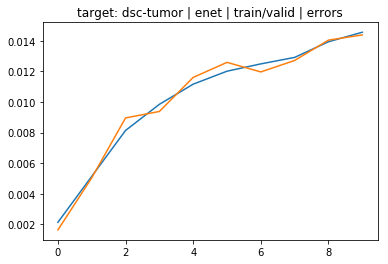

In [22]:
viewer = cnn.Viewer('./exps/unet/exp01')
viewer.graph(name='enet', node='errors', target='dsc-tumor', key=3)